# The importance of conservation form

For a nonlinear problem like Burgers' equation, it is important to use a finite volume method that is in conservation form, or it is possible to converge to a function containing a shock wave that is not a solution of intended conservation law.

This illustrates Figure 12.5 in [FVMHP](http://depts.washington.edu/clawpack/book.html).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function

In [3]:
import animation_tools  # local version, rather than from Clawpack

In [4]:
#animation_style = 'ipywidgets'
animation_style = 'JSAnimation'

## Desired true solution

Define the true solution as a function of $(x,t)$. For this example we have a Riemann problem with a shock wave solution.

Evaluating this function at $t=0$ will give the initial conditions below.

In [5]:
f = lambda q: 0.5*q**2

q_left = 3.
q_right = 1.
s = 0.5*(q_left + q_right)

xlower = -1.
xupper = 3.

def qtrue(x,t):
    # Riemann problem, assuming shock wave solution:
    x0 = x - s*t   # trace back characteristic to time 0
    q = where(x0<0, q_left, q_right) 
    return q

### Define upwind method with both conservative and non-conservative variants

Consider Burgers' Equation $q_t + \left(\frac 1 2 q^2\right)_x = 0$.

We assume $Q_i^n > 0$ everywhere so the upwind direction is to the left.

If `conservative = True` in the call to `upwind`, the conservative upwind method is used, differencing the flux function $f(q) = \frac 1 2 q^2$:
$$
Q_i^{n+1} = Q_i^n - \frac{\Delta t}{\Delta x} \left( \frac 1 2 (Q_i^n)^2 - \frac 1 2 (Q_{i-1}^n)^2 \right)
$$

If `conservative = False` in the call to `upwind`, the non-conservative upwind method is used, based on the quasi-linear form of Burgers' equation $q_t + qq_x = 0$:

$$
Q_i^{n+1} = Q_i^n - \frac{\Delta t}{\Delta x} Q_i^n \left( Q_i^n - Q_{i-1}^n \right)
$$

This function also make a plot every `nplot` time steps and accumulate these in `figs`, which is returned from the function call.


In [6]:
def upwind(x,tfinal,nsteps,dt,qtrue,nplot,conservative):
    
    dx = x[1] - x[0]  # assumes uniform grid
    
    # set initial data:
    q0 = qtrue(x,0.)

    # plot initial data:
    fig = figure()
    xfine = linspace(xlower,xupper,5000)   # fine grid for plotting true solution
    plot(xfine, qtrue(xfine,0.),'r-')
    title('Initial data')
    plot(x,q0,'bo')
    ylim(0,4)

    # Start accumulating figures
    # Will add more figures during time stepping
    figs = [fig]  
    close(fig)  # so it won't appear yet


    # extend to include 2 ghost cells on each side:
    qn_ext = hstack([0., 0., q0, 0., 0.])
    i1 = 2  # index of first interior cell
    imx = mx+1  # index of last interior cell

    for n in range(1, nsteps+1):

        # fill ghost cells for inflow BCs:
        qn_ext[i1-2] = q_left
        qn_ext[i1-1] = q_left
        #qn_ext[imx+1] = Not needed
        #qn_ext[imx+2] = 

        qnp_ext = qn_ext.copy()  # make a copy, not a new pointer to old array

        
        if conservative:
            for i in range(i1,imx+1):
                qnp_ext[i] = qn_ext[i] - dt/dx * (f(qn_ext[i])-f(qn_ext[i-1]))
                
        else:
            for i in range(i1,imx+1):
                qnp_ext[i] = qn_ext[i] - dt/dx * qn_ext[i]*(qn_ext[i]-qn_ext[i-1])

                
        qn_ext = qnp_ext

        if mod(n,nplot) == 0:
            fig = figure()
            qn = qn_ext[i1:imx+1]
            plot(x,qn,'bo-')
            ylim(0,4)
            tn = n*dt
            plot(xfine, qtrue(xfine,tn),'r-')
            title('Time t = %g' % tfinal)
            figs.append(fig)
            close(fig)

    print("Took %i time steps and produced %i figures" % (nsteps,len(figs)))
    return figs

In [7]:
mx = 100
dx = float(xupper-xlower)/mx

# finite volume cell centers:
x = linspace(xlower+0.5*dx, xupper-0.5*dx, mx)

tfinal = 1.0
nsteps = 100
dt = float(tfinal)/nsteps
cfl = max(q_left, q_right)*dt/dx
print("dx = %6.4f, dt = %6.4f, Courant number is cfl = %5.2f" % (dx,dt,cfl))

dx = 0.0400, dt = 0.0100, Courant number is cfl =  0.75


## Test the conservative upwind method:

Took 100 time steps and produced 21 figures



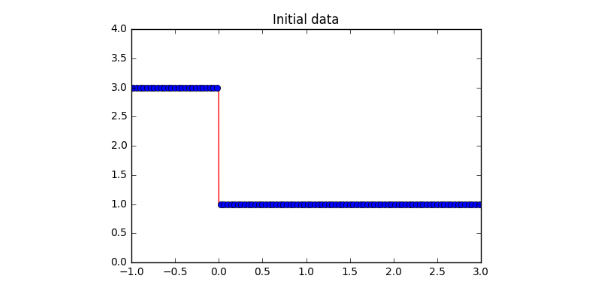
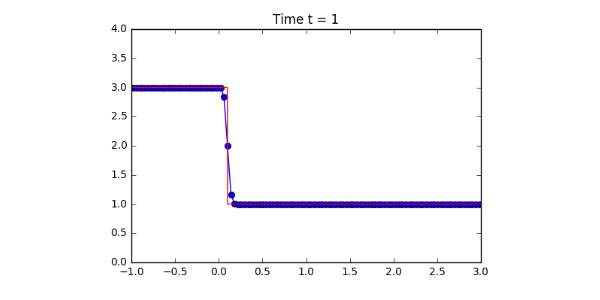
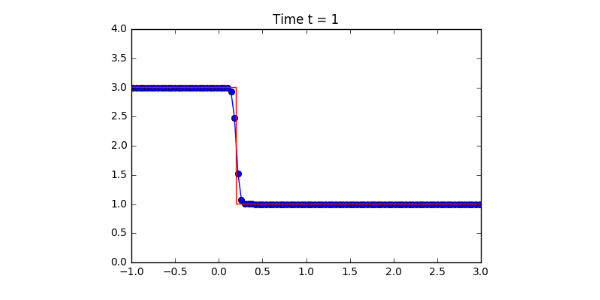
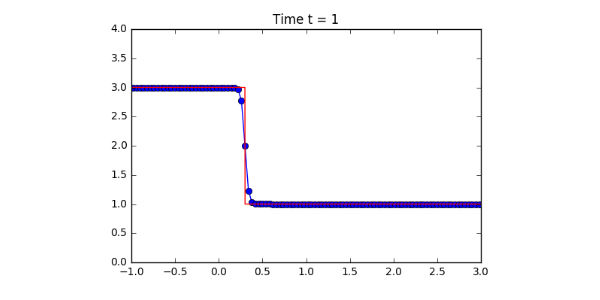
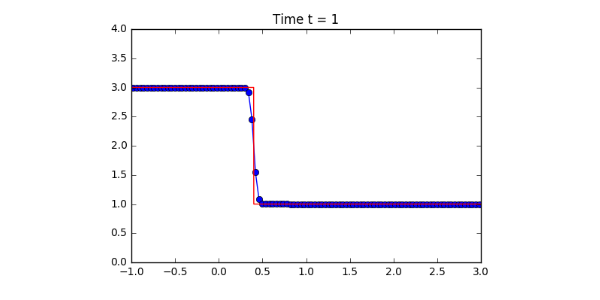
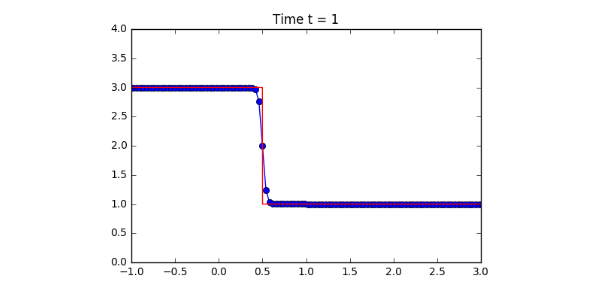
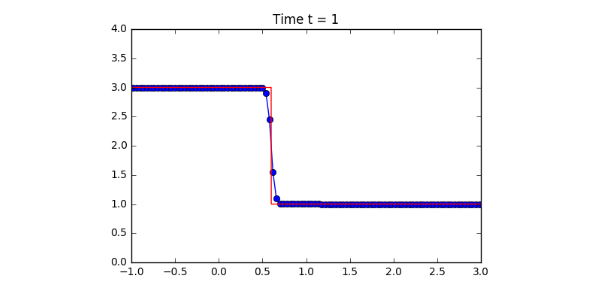
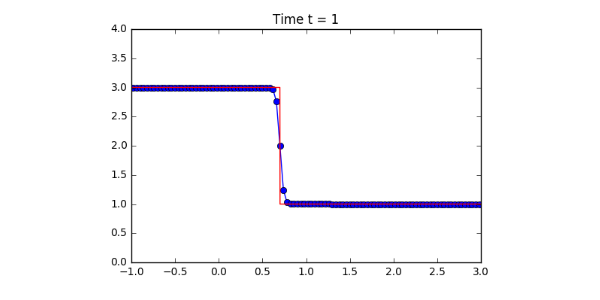
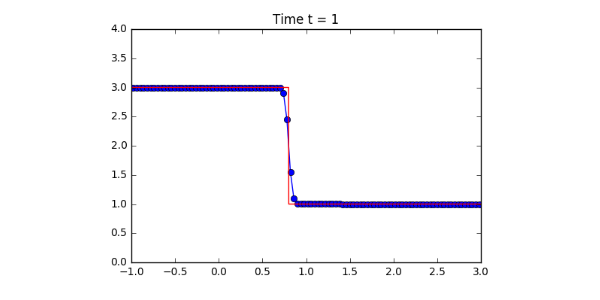
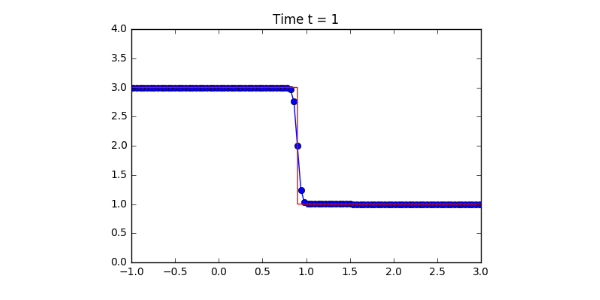
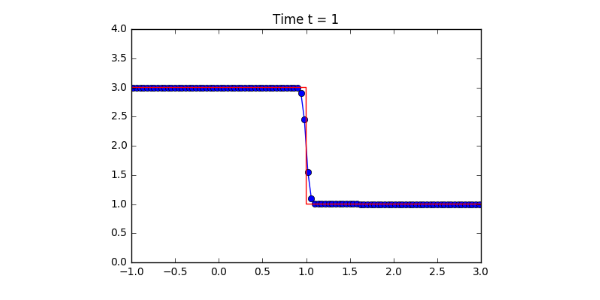
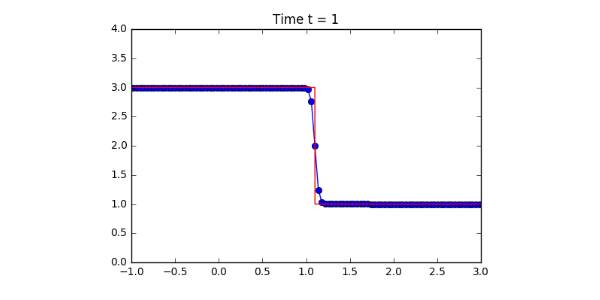
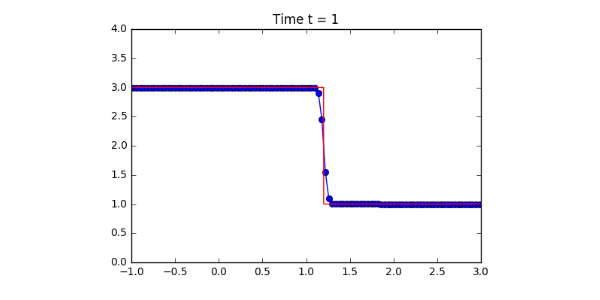
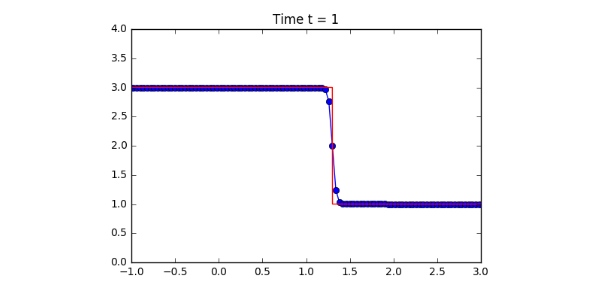
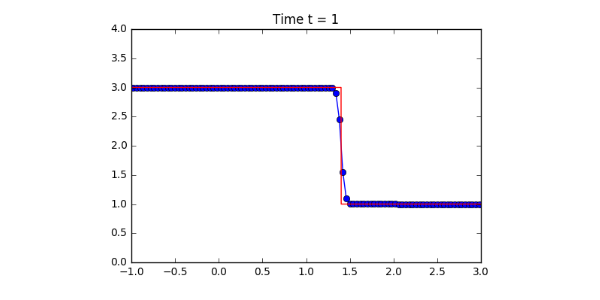
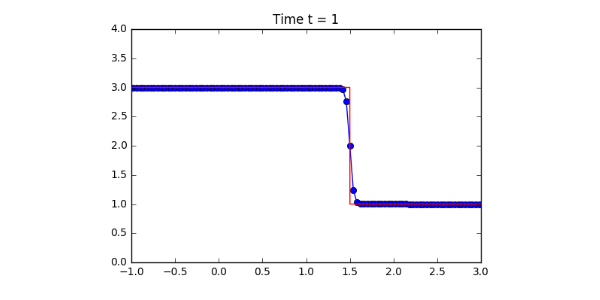
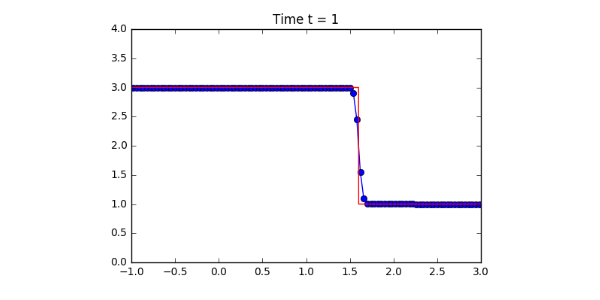
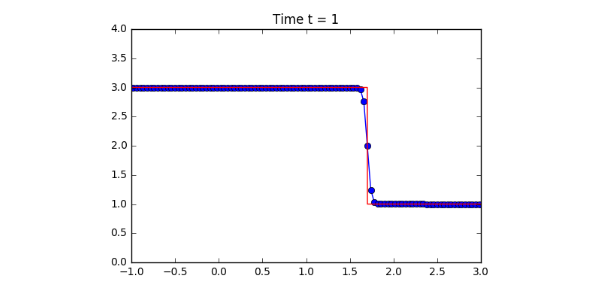
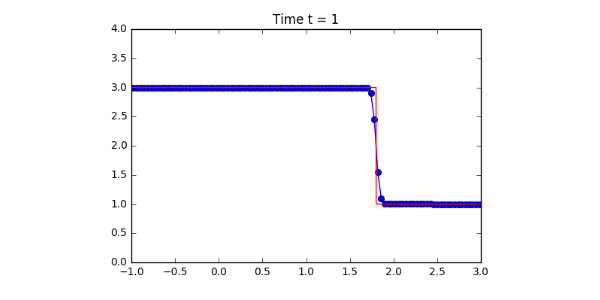
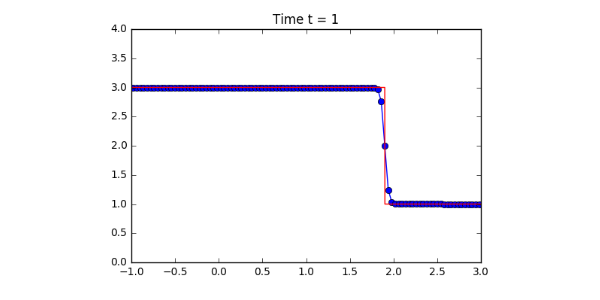
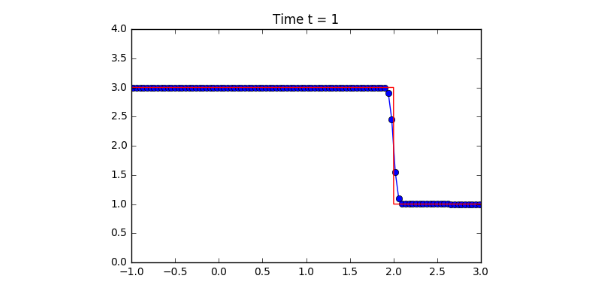

In [8]:
figs = upwind(x,tfinal,nsteps,dt,qtrue,nplot=5,conservative=True)

anim = animation_tools.animate_figs(figs, style=animation_style, figsize=(6,3))
display(anim)

Took 100 time steps and produced 21 figures



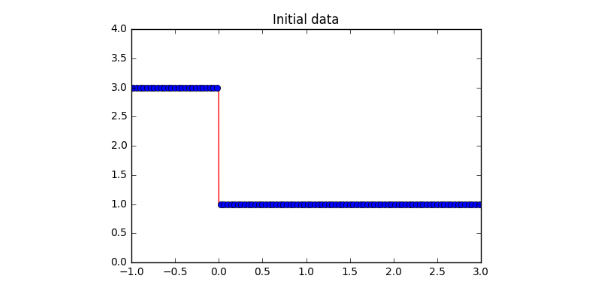
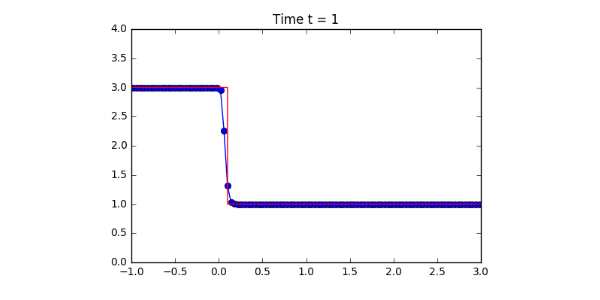
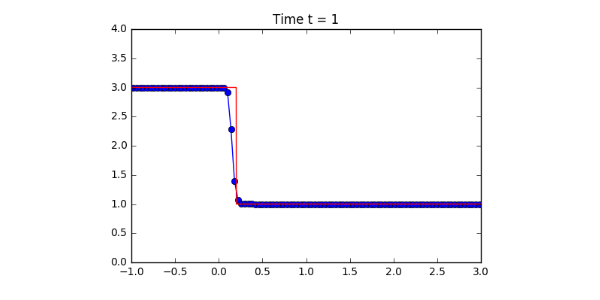
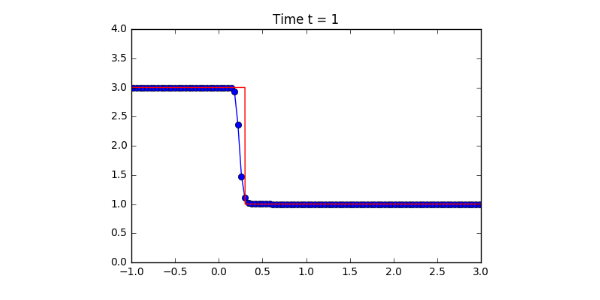
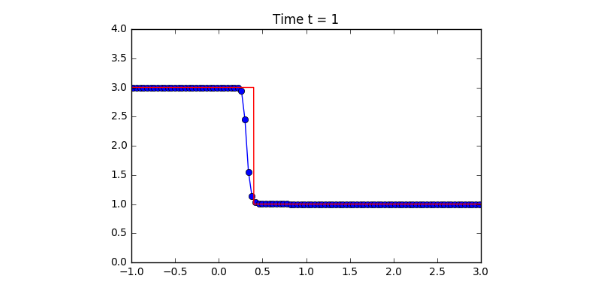
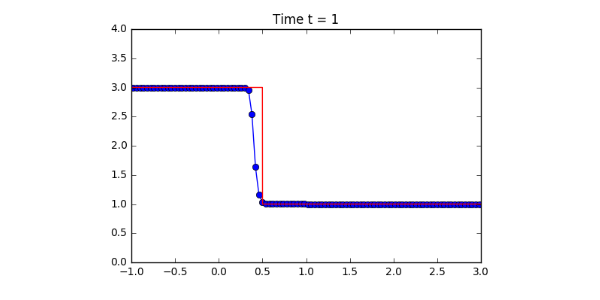
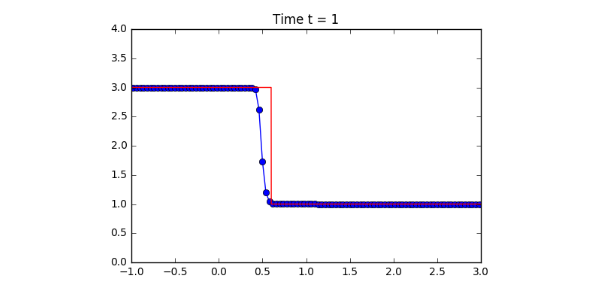
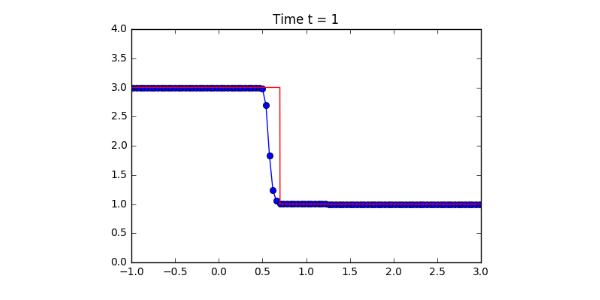
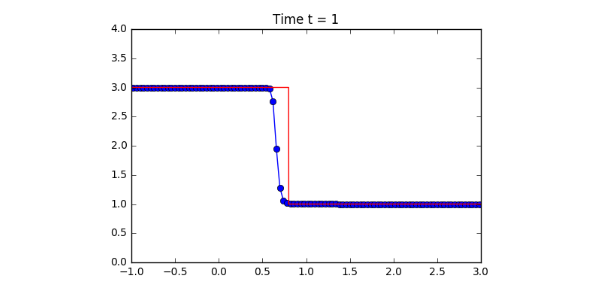
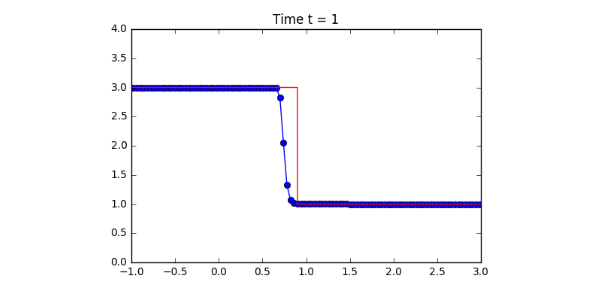
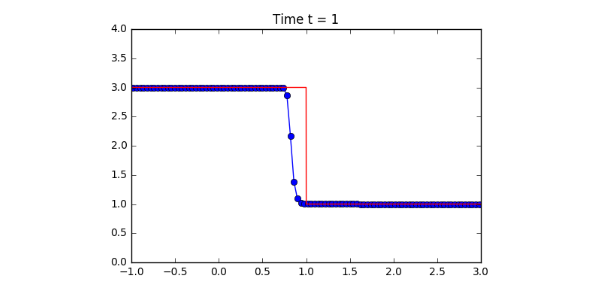
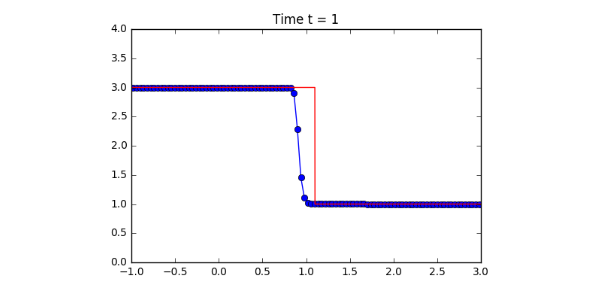
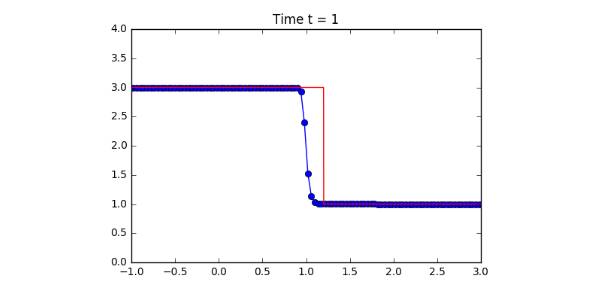
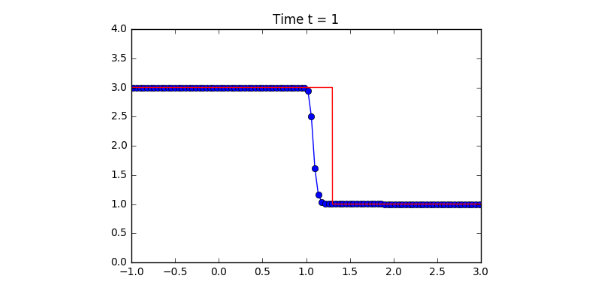
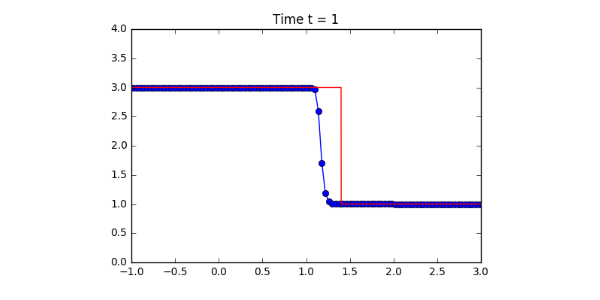
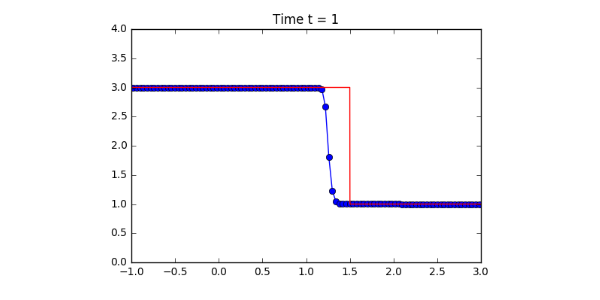
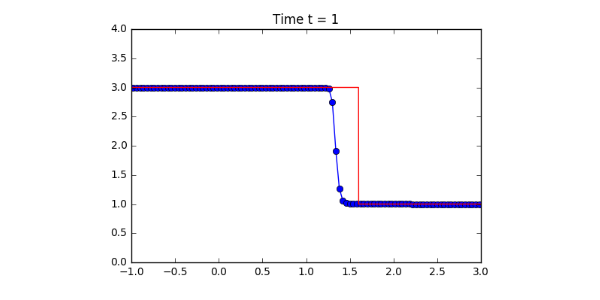
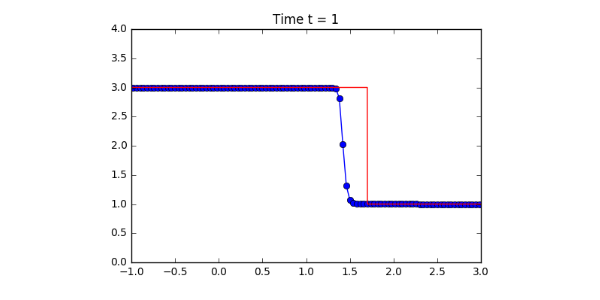
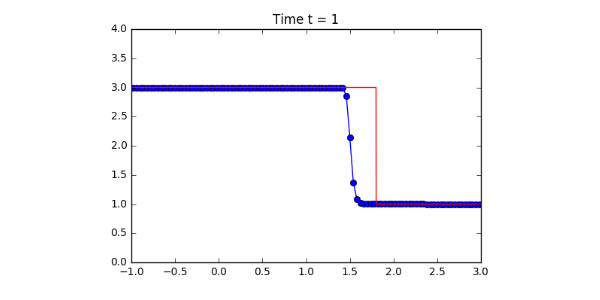
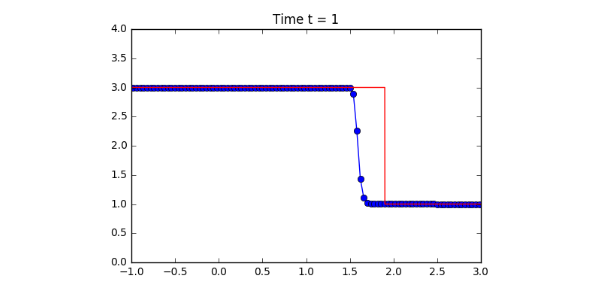
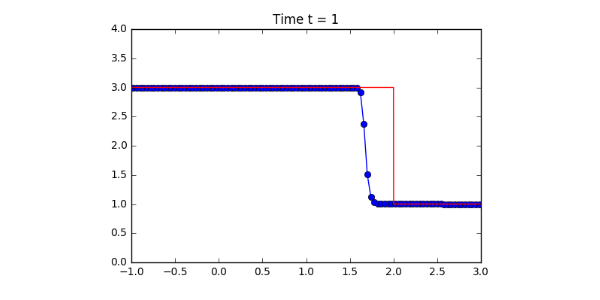

In [9]:
figs = upwind(x,tfinal,nsteps,dt,qtrue,nplot=5,conservative=False)

anim = animation_tools.animate_figs(figs, style=animation_style, figsize=(6,3))
display(anim)